<a href="https://colab.research.google.com/github/pabloapablaza/inteligenciacomputacional/blob/master/Style_Transfer_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Proyecto Style Transfer**
#####**EL4106 Inteligencia Computacional**



En este proyecto se busca implementar un algoritmo de transferencia de estilo de imágenes, en base al trabajo *A Neural Algorithm of Artistic Style*, el cual realiza el trabajo en base a redes neuronales convolucionales.

El trabajo se realiza principalmente utilizando la librería Tensorflow 2, a partir de un modelo pre-entrenado de la red neuronal convolucional VGG19 provista por Keras.

###**Importar librerias y cargar imagenes** 

####**Cargar librerias y subir imagenes**

In [2]:
#Importar librerias
import os
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import PIL.Image
import time
import functools
from google.colab import files
import time

In [1]:
#Importar modelo red VGG19 de Keras
import tensorflow.keras.applications.vgg19 as vgg19

In [9]:
#Subir archivos 
files.upload()

Saving chile.jpg to chile.jpg
Saving klimt.jpg to klimt.jpg


{'chile.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\n\x14\x0e\x0f\x0c\x10\x17\x14\x18\x18\x17\x14\x16\x16\x1a\x1d%\x1f\x1a\x1b#\x1c\x16\x16 , #&\')*)\x19\x1f-0-(0%()(\xff\xdb\x00C\x01\x07\x07\x07\n\x08\n\x13\n\n\x13(\x1a\x16\x1a((((((((((((((((((((((((((((((((((((((((((((((((((\xff\xc2\x00\x11\x08\x02\xc1\x04\xec\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x02\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x04\x01\x02\x05\x00\x06\x07\x08\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x00\x04\x05\x06\xff\xda\x00\x0c\x03\x01\x00\x02\x10\x03\x10\x00\x00\x01\xf0\x94\x9a\xa5\xe9\x04\xb0p\xc9*-\x1dj\x83Z^\xad)0\xd8~X\xa9\x85\x9c\x1d<\xb7\xe8\xee\r\xd3\x13\xb4V\xd4h\xf5\xc6F\xe7e\xe0\xe8\xb2\xd9\xaa\x97\n&\xe2A\xb3\xd3i\x0cLd\x8b\x95\xfb)m\x8c*\xc61=\x03uf\x87t\xd2q\xbd\x83\xd8\x1aW\xed\x9d*W\x05\

In [42]:
#Definir paths donde se encuentran las imagenes
style_path = '/content/chile.jpg'
content_path = '/content/klimt.jpg'

####**Funciones utiles para cargar y graficar imagenes**

In [43]:
def tensor_to_image(tensor):

  """Funcion que permite pasar de tensor (4D) a imagen (3D).
  Se reducen las dimensiones de la imagen y se multiplica por 255 el
  valor del tensor para pasar a valores RGB"""

  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)

  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
    
  return PIL.Image.fromarray(tensor)

In [44]:
def load_img(path):

  """Carga las imagenes especificadas en path y reescala con tal 
  que la dimension mas larga sea de 512px"""

  max_dim = 512
  img = tf.io.read_file(path)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [45]:
def plot_img(image, title=None):

  """Funcion para graficar las imagenes cargadas"""

  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [46]:
def plot_pairs(content, style, dims):

  """Grafica pares de imagenes para mostrar contenido y estilo juntos con la dimension
  especificada"""

  if content !=None and style!=None:
    plt.figure(figsize = (dims, dims))

    plt.subplot(1, 2, 1)
    plot_img(content, 'Imagen de contenido')

    plt.subplot(1, 2, 2)
    plot_img(style, 'Imagen de estilo')

####**Cargar y mostrar imagenes de contenido y estilo**

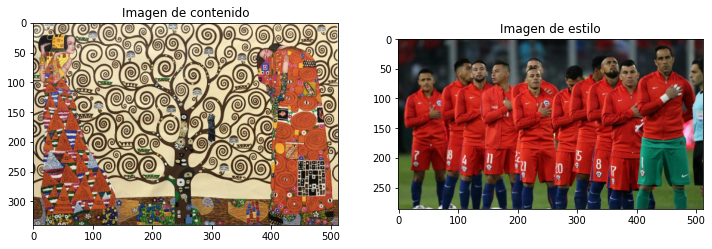

In [47]:
#Cargar contenido, estilo y plotear
content_img = load_img(content_path)
style_img = load_img(style_path)
plot_pairs(content_img, style_img, 12)

###**Modelo de red VGG19** 

####**Visualizar modelo VGG19**

En esta sección se hace el llamado al modelo pre-entrenado VGG19 de Keras, el cual se carga sin cabezal de clasificación (fully-connected) ya que en el paper se recomienda eliminarlo, además de que no se están realizando tareas de clasificación, sino que de **extracción de características**.

En la siguiente función se genera el modelo de red VGG19 modificado para realizar la implementación del *style transfer*. La red posee 16 capas convolucionales y 5 de pooling.

In [48]:
#Cargar modelo de red VGG19 con los pesos de imagenet e imprimir capas
#Modelo sin fully connected y con avgpooling como recomienda el paper
vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet', pooling='avg')
print('***CAPAS VGG19 SIN FULLY CONNECTED***')
for layer in vgg19.layers:
  print(layer.name)

***CAPAS VGG19 SIN FULLY CONNECTED***
input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
global_average_pooling2d_3


####**Capas de representacion de estilo y contenido**

Se establecen las capas para definir el contenido y el estilo de la imagen. En base al paper se escoge para el contenido la capa **conv4_2** y para el estilo las capas **conv1_1, conv2_1, conv3_1, conv4_1 y conv5_1**.

In [49]:
#Definir capas del modelo para definir el contenido y el estilo
content_lay=['block4_conv2']
style_lay=['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

#Numero de capas para estilo y contenido
num_content_lay=len(style_lay)
num_style_lay=len(content_lay)

####**Construcción modelo VGG19**

Se define una función que permite extraer las capas del modelo VGG19, de manera de poder utilizarlas para extracción de estilo y extracción de características en base a las listas *content_lay* y *style_lay*, en las cuales se encuentran las capas a utilizar para contenido y estilo. 

In [50]:
def vgg_layers(lay_names):

  """Funcion que retorna las capas seleccionadas del modelo VGG19 dentro de la 
  lista lay_names.
  
  Esta funcion permite las capas para extraccion de estilo y características"""

  #Modelo preentrenado VGG19
  vgg = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet', pooling='avg') 
  vgg.trainable = False

  #Lista con las capas requeridas según estilo o contenido
  salidas = [vgg.get_layer(name).output for name in lay_names]

  model = tf.keras.Model([vgg.input], salidas)
  return model

A continuación, se define el extractor de caracteristicas en base a la funcion *vgg_layers*, la cual crea el modelo en base a las capas para extraer caracteristicas.

Con el modelo creado, se utiliza como input a la imagen de estilo *style_img*, la cual se procesa en el modelo. 

In [51]:
style_extr = vgg_layers(style_lay) #Extractor de estilo (capas convolucionales)
style_out = style_extr(style_img * 255) #Extraer caracteristicas a la imagen de estilo 

#Imprimir caracteristicas de las capas utilizadas para estilo
print('***STYLE EXTRACTOR OUTPUT***')
for name, output in zip(style_lay, style_out):
  print(name)
  print('   shape: ', output.numpy().shape)
  print('   min: ', output.numpy().min())
  print('   max: ', output.numpy().max())
  print('   mean: ', output.numpy().mean())
  print() 

***STYLE EXTRACTOR OUTPUT***
block1_conv1
   shape:  (1, 286, 512, 64)
   min:  0.0
   max:  811.4107
   mean:  30.058512

block2_conv1
   shape:  (1, 143, 256, 128)
   min:  0.0
   max:  4333.7144
   mean:  140.97325

block3_conv1
   shape:  (1, 71, 128, 256)
   min:  0.0
   max:  7755.757
   mean:  162.91754

block4_conv1
   shape:  (1, 35, 64, 512)
   min:  0.0
   max:  24835.787
   mean:  605.879

block5_conv1
   shape:  (1, 17, 32, 512)
   min:  0.0
   max:  3228.5667
   mean:  54.635994



###**Error y estilo** 

Se calcula la **matriz de gram** para medir la correlación entre

In [52]:
def gram(input):

  """Calcula la matriz de Gram (Gram matrix) para el tensor de entrada (input)"""

  matrix = tf.linalg.einsum('bijc, bijd->bcd', input, input) #Computar 
  input_shape = tf.shape(input)
  cte = tf.cast(input_shape[1] * input_shape[2], tf.float32)
  result = matrix/cte #Se divide por la cantidad de pixeles. Se obtiene el resultado.
  
  return result

In [53]:
class ContenidoyEstilo(tf.keras.models.Model):

  #Input son las capas de contenido y estilo (las necesarias para el modelo)
  def __init__(self, style_layers, content_layers): 
    super(ContenidoyEstilo, self).__init__()

    """Se definen las variables de la clase"""

    self.vgg = vgg_layers(style_layers + content_layers) #Capas convolucionales del modelo
    self.style_layers = style_layers #Capas de estilo
    self.content_layers = content_layers #Capas de contenido
    self.num_style_layers = len(style_layers) #Cantidad de capas de estilo
    self.vgg.trainable = False #Modelo no entrenable

  def call(self, inputs):
    inputs =  inputs * 255.0 #La imagen viene en [0,1] por lo que se pasa a RGB
    #Preprocesar la entrada con la funcion de Keras 
    preproc_input = tf.keras.applications.vgg19.preprocess_input(inputs)

    outputs = self.vgg(preproc_input) #Procesar la entrada preprocesada en el modelo vgg.

    #Capas de estilo y de contenido a partir del modelo VGG19
    style_out, content_out = (outputs[:self.num_style_layers],
                              outputs[self.num_style_layers:])
    
    #Se calcula la matriz de gram para el estilo
    style_out = [gram(style_out) for style_out in style_out]
    
    #Diccionario con el nombre de la capa de contenido y el valor del tensor
    content_dict = {content_name: value for content_name, value in zip(self.content_layers,
                                                                       content_out)}

    #Diccionario con los nombres de las capas de estilo y valores de tensores
    style_dict = {style_name: value for style_name, value in zip(self.style_layers,
                                                                  style_out)}
    content_n_style = {'content': content_dict, 'style': style_dict}
    return content_n_style

In [54]:
#Llamado a la clase para extraer contenido y estilo
extract = ContenidoyEstilo(style_lay, content_lay)
#Tensores sobre los cuales se ejecuta la actualización por gradiente 
style_target = extract(style_img)['style'] #Capas convolucionales de estilo
content_target = extract(content_img)['content'] #Capas convolucionales de caracteristicas

In [55]:
def clip_01(img):
  """Funcion para mantener los valores del tensor entre 0 y 1"""
  clip = tf.clip_by_value(img, clip_value_min=0.0, clip_value_max=1.0)
  return clip

In [56]:
#Optimizador para aplicar la actualizacion
optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [57]:
#Definicion de pesos para las funciones de costo

style_weight=0.01 #beta original 1e-2
content_weight=0.7 #alpha original 1e4

#Hacer dependencia con una variable 

style_weights={'block1_conv1': 0.2, #pesos para las capas en la funcion de style_loss
               'block2_conv1': 0.2,
               'block3_conv1': 0.2,
               'block4_conv1': 0.2,
               'block5_conv1': 0.2}

Se define la ecuación (1) del paper, que corresponde a la función de costos que relaciona la imagen original con la imagen generada. En particular, $P^{l}$ y $F^{l}$ son las representaciones de caracteristicas en la capa $l$:

$$\mathcal{L}_{content} (\vec{p},\vec{x},l)=\frac{1}{2}\sum_{i, j} (F_{ij}^{l}-P_{ij}^{l})$$



*   $\vec{p}$ imagen original.
*   $\vec{x}$ imagen generada.
*   $l$ capa donde se calcula el costo.

Ahora se define la ecuación (5) del paper, la cual corresponde a la función de costos para el estilo:

$$\mathcal{L}_{style} (\vec{a},\vec{x})=\sum_{l=0}^{L} w_{l}E_{l}$$

* $\vec{a}$ es la imagen original.
* $\vec{x}$ es la imagen que es generada a partir del estilo.
*   $w_{l}$ son los factores de la contribución de cada capa a la función de costos. **Estos parámetros son importantes ya que ajustan los resultados del modelo** pues 'pesan' la contribución de cada capa al error. 

Además, $E_{l}$ es la contribución de cada capa al error total. Esté parámetro está dado por:

$$E_{l}=\frac{1}{4N_{l}^{2}M_{l}^{2}}\sum_{i,j}(G_{ij}^{l}-A_{ij}^{l})^{2}$$

$$L_{total}=\alpha\mathcal{L}_{content}+\beta\mathcal{L}_{style}$$







In [58]:
def style_content_loss(outputs):
    """Funcion en la cual se calcula el error total en base a la funcion de costos 
    definida en el paper. Los pesos se modifican en las variables del chunk anterior"""
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_target[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight #/ num_style_lay. Se elimina para aplicar afuera

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_target[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight #/ num_content_lay
    loss = style_loss + content_loss
    return loss

###**Entrenamiento y resultados** 

In [68]:
@tf.function()
def train_step(image):

  """Funcion que realiza el paso de entrenamiento por gradiente descendente"""

  with tf.GradientTape() as tape:
    #Extraer características
    outputs = extract(image)
    #Calcular el error
    loss = style_content_loss(outputs)
  #Determinar los gradientes del error con respecto a la imagen
  grad = tape.gradient(loss, image)

  #Actualizar los gradientes
  optimizer.apply_gradients([(grad, image)])

  #mantener valores de los pixeles entre 0 y 1 para ser decodificado como RGB despues
  image.assign(clip_01(image))

In [69]:
def stilyze_img(img):
  "Funcion que realiza la aplicación del estilo a la imagen img"
  start = time.time()

  epochs = 50
  steps_per_epoch = 100

  step = 0
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
      train_step(img)
      print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(img))
    print("Train step: {}".format(step))
    
  end = time.time()
  print("Total time: {:.1f}".format(end-start))

In [70]:
img = tf.Variable(content_img) #Imagen con el contenido

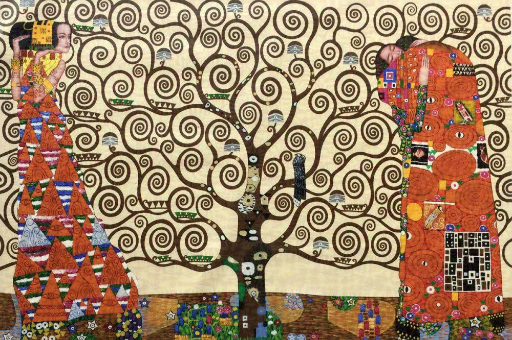

In [71]:
train_step(img)
train_step(img)
train_step(img)
tensor_to_image(img)

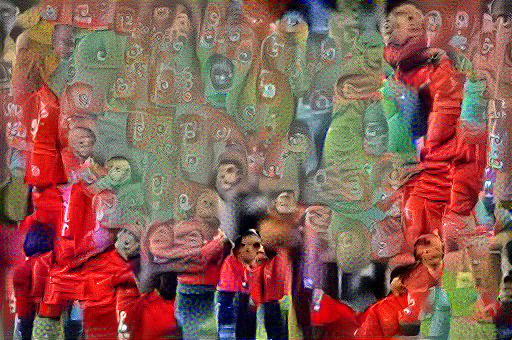

Train step: 5000
Total time: 300.3


In [72]:
stilyze_img(img)

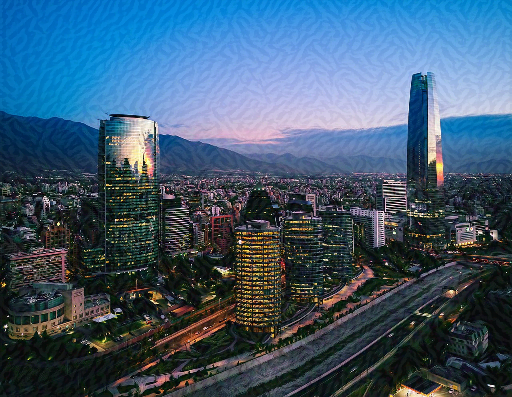

In [ ]:
train_step(img)
train_step(img)
train_step(img)
tensor_to_image(img)

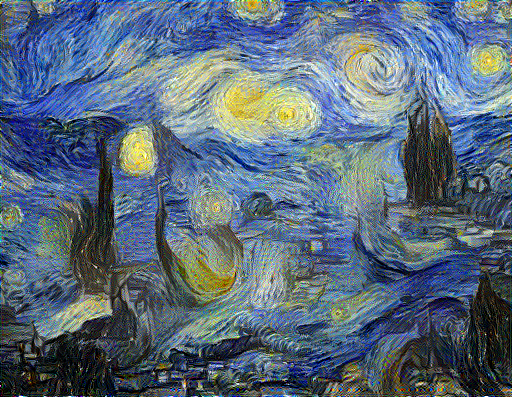

Train step: 20000
Total time: 1473.0


In [ ]:
stilyze_img(img)

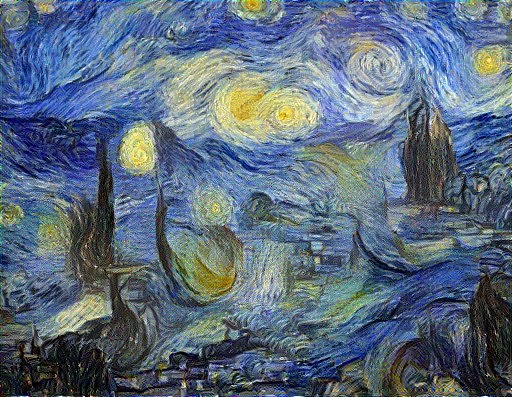

Train step: 10000
Total time: 735.8


In [ ]:
stilyze_img(img)

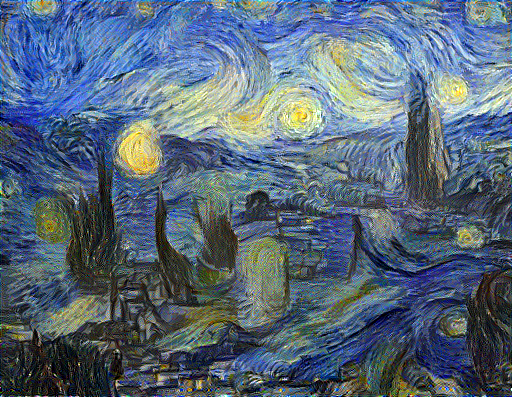

Train step: 10000
Total time: 736.7


In [ ]:
stilyze_img(img)

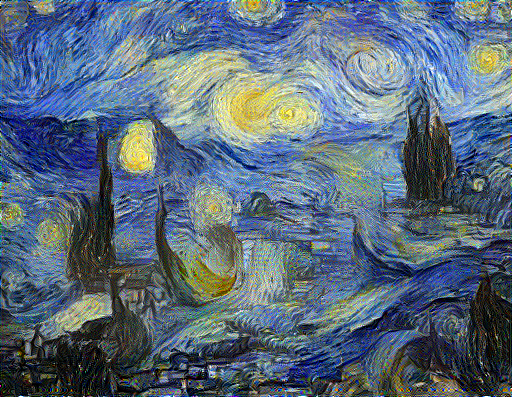

Train step: 20000
Total time: 1472.3


In [ ]:
stilyze_img(img)

###Fuentes


*   Gatys L. and Ecker A. and Bethge M. *A Neural Algorithm of Artistic Style*
* [Transferencia de estilo neuronal](https://www.tensorflow.org/tutorials/generative/style_transfer)
*[VGG19 Model Keras](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG19)
*[Preprocesamiento para VGG19](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg19/preprocess_input)